In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from tqdm import tqdm
import tables
from io import TextIOWrapper
from pathlib import Path
import glob
import neurokit2 as nk
from ecgdetectors import Detectors
import time
import seaborn as sns
import scipy.stats as stats
from hrvanalysis import get_time_domain_features
from scipy.stats import levene
import os

In [69]:
# Cargar archivo
df = pd.read_excel('./data/Diagnostics.xlsx')

# Mostrar dimensiones y primeras filas
print("Dimensiones:", df.shape)
x= df.head()
print('\n',x)

Dimensiones: (10646, 16)

                      FileName Rhythm       Beat  PatientAge  Gender  \
0  MUSE_20180113_171327_27000   AFIB   RBBB TWC          85    MALE   
1  MUSE_20180112_073319_29000     SB        TWC          59  FEMALE   
2  MUSE_20180111_165520_97000     SA       NONE          20  FEMALE   
3  MUSE_20180113_121940_44000     SB       NONE          66    MALE   
4  MUSE_20180112_122850_57000     AF  STDD STTC          73  FEMALE   

   VentricularRate  AtrialRate  QRSDuration  QTInterval  QTCorrected  RAxis  \
0              117         234          114         356          496     81   
1               52          52           92         432          401     76   
2               67          67           82         382          403     88   
3               53          53           96         456          427     34   
4              162         162          114         252          413     68   

   TAxis  QRSCount  QOnset  QOffset  TOffset  
0    -27        19     2

In [70]:
# Columna de arritmia
arritmia_counts = df['Rhythm'].value_counts()
print('\n Total por cada arritmia: \n\n',arritmia_counts)


 Total por cada arritmia: 

 Rhythm
SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: count, dtype: int64


In [71]:
# Genero
arritmia_gender = df.groupby(['Gender', 'Rhythm']).size().unstack().fillna(0)
print('\n Arritmias por genero:\n\n',arritmia_gender)



 Arritmias por genero:

 Rhythm   AF  AFIB  AT  AVNRT  AVRT   SA  SAAWR    SB    SR   ST  SVT
Gender                                                              
FEMALE  188   739  57     12     3  176      6  1408  1024  769  308
MALE    257  1041  64      4     5  223      1  2481   802  799  279


In [ ]:
# Analisis rango de edad
edad_maxima = df['PatientAge'].max()
print("Edad máxima:", edad_maxima)
edad_minima = df['PatientAge'].min()
print("Edad mínima:", edad_minima)


Edad máxima: 98
Edad mínima: 4


In [75]:
# Filtro edad con al menos 100 pacientes
conteo_por_edad = df['PatientAge'].value_counts().sort_index()
edades_validas = conteo_por_edad[conteo_por_edad >= 100].index
df_edad_filtrada = df[df['PatientAge'].isin(edades_validas)]

# Filtro por arritmia con al menos 100 casos
conteo_arritmia = df_edad_filtrada['Rhythm'].value_counts()
arritmias_validas = conteo_arritmia[conteo_arritmia >= 100].index
df_filtrado_final = df_edad_filtrada[df_edad_filtrada['Rhythm'].isin(arritmias_validas)]

# Total pacientes filtrado
total_pacientes_filtrados = len(df_filtrado_final)
print(f"Total de pacientes tras ambos filtros (edad y arritmia): {total_pacientes_filtrados}")
# Porcentaje de datos
total_pacientes_inicial = 10646
porcentaje_pacientes_filtrados = (total_pacientes_filtrados / total_pacientes_inicial) * 100
print(f"Porcentaje de pacientes tras ambos filtros (edad y arritmia): {porcentaje_pacientes_filtrados:.2f}%")

# Cantidad pacientes en cada tipo de arritmia
print("\nCantidad de pacientes por tipo de arritmia (>=100 casos):")
print(df_filtrado_final['Rhythm'].value_counts())

# Pacientes totales por edad
print("\nCantidad de pacientes por edad:")
print(df_filtrado_final['PatientAge'].value_counts().sort_index())

# DataFrame filtrado
df_filtrado_final.to_excel('./data/Diagnosticsfiltered.xlsx', index=False)



Total de pacientes tras ambos filtros (edad y arritmia): 8186
Porcentaje de pacientes tras ambos filtros (edad y arritmia): 76.89%

Cantidad de pacientes por tipo de arritmia (>=100 casos):
Rhythm
SB      3317
AFIB    1548
SR      1357
ST      1066
SVT      396
AF       370
SA       132
Name: count, dtype: int64

Cantidad de pacientes por edad:
PatientAge
44    124
45    133
46    134
47    151
48    171
49    168
50    191
51    220
52    211
53    236
54    235
55    187
56    171
57    175
58    189
59    213
60    254
61    247
62    239
63    263
64    266
65    244
66    210
67    281
68    275
69    305
70    231
71    245
72    209
73    163
74    173
75    172
76    160
77    148
78    144
79    171
80    172
81    162
82    148
83    177
84    116
85    102
Name: count, dtype: int64


In [ ]:
'''comprimir los datos para una lectura mas rapido de las señales'''

BASE_PATH = Path('./data') # Ruta principal de los datos
ZIP_PATH = BASE_PATH/'ECGDataDenoised.zip'
PROCESSED_DIR = BASE_PATH/'processed' # Ruta donde se almacenaran los archivos procesados

# verificacion de la carpeta para el almacenamiento de los archivos
(PROCESSED_DIR/'parquet').mkdir(parents=True, exist_ok=True)

# Leer datos
diagnostics = pd.read_excel(BASE_PATH/'Diagnosticsfiltered.xlsx')
arritmias = ['AFIB', 'SB', 'SR', 'ST', 'SVT', 'AF', 'SA']

# Extraemos los nombres de los archivos en diagnosticfiltered
print("Organizando archivos por tipo de arritmia...")
archivos_por_arritmia = {
    arritmia: diagnostics[diagnostics['Rhythm'] == arritmia]['FileName'].dropna().tolist()
    for arritmia in arritmias # Agrupamos los archivos por cada arritmia
}



# Buscamos los archivos de diagnosticfiltered en ECgDataDenoised
def encontrar_archivo_csv(zip_ref, filename):
    # Buscamos la extensiones CSV, ponemos pruebas de varias posibles formas de escritura del archivo
    posibles_variantes = [
        f"{filename}.csv",
        f"{filename}.CSV",
        f"{filename}_ECG.csv",
        f"{filename.replace(' ', '_')}.csv"
    ]
    
    for variant in posibles_variantes:
        if variant in zip_ref.namelist():
            return variant
    
    # Busqueda por si no coincide exactamente, buscamos la terminacion en csv o filename
    for file_in_zip in zip_ref.namelist():
        if filename in file_in_zip and file_in_zip.lower().endswith('.csv'):
            return file_in_zip
    
    return None



# Cargamos la señal CSV
def cargar_señal_csv(archivo_zip, zip_ref):
    with zip_ref.open(archivo_zip) as f:
        # Leer como texto para saber el separador
        text_f = TextIOWrapper(f, encoding='utf-8')
        peek = text_f.readline() + text_f.readline() # Leemos las primeras líneas para identificar el separador
        text_f.seek(0)
        
        # Separador del archivo CSV
        separator = ',' if ',' in peek else (';' if ';' in peek else '\t')
        text_f.seek(0)
        
        # Lemmos el CSV con el separador
        df = pd.read_csv(text_f, sep=separator)
        
        # Identificar las columnas en el ECG
        ecg_columns = [col for col in df.columns 
                      if 'ecg' in col.lower() 
                      or 'signal' in col.lower() 
                      or 'lead' in col.lower()
                      or 'mlii' in col.lower()]
        
        if not ecg_columns:
            # Si no encuentra para identificar coge la primera columna
            ecg_columns = [df.select_dtypes(include=[np.number]).columns[0]]
        
        return df[ecg_columns[0]].values # Retornamos la señal ECG



# Funcion para convertir a Parquet (lectura mas rapido de los archivos)
def convertir_a_parquet(zip_path, archivos, output_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for filename in tqdm(archivos, desc=f'Convirtiendo a Parquet'):
            archivo_zip = encontrar_archivo_csv(zip_ref, filename) # Buscamos el archivo CSV en el ZIP
            
            if not archivo_zip:
                print(f"\nAdvertencia: No se encontró CSV para {filename}") # Alerta si no encuentra el archivo
                continue
                
            try:
                señal = cargar_señal_csv(archivo_zip, zip_ref) # Cargamos la señal ECG desde el archivo
                
                # Como quedan los datos en el dataframe
                df = pd.DataFrame({
                    'timestamp': np.arange(len(señal)),
                    'ecg_signal': señal
                })
                
                output_path = Path(output_dir)/f"{Path(archivo_zip).stem}.parquet" # Ruta donde se guardara y guardamos el DataFrame en formato Parquet
                df.to_parquet(
                    output_path,
                    engine='pyarrow',
                    compression='snappy',
                    row_group_size=min(100000, len(señal))
                )
            except Exception as e:
                print(f"\nError procesando {archivo_zip}: {str(e)}")




# Ejecucion del reporte
print("\nIniciando conversión...")
for arritmia, archivos in archivos_por_arritmia.items():
    print(f"\n{'='*50}")
    print(f"Procesando {arritmia} ({len(archivos)} archivos)") # Mostramos el progreso por arritmia
    print(f"{'='*50}")
    
    # Creamos las carpetas para almacenar los archivos Parquet de cada arritmia
    parquet_dir = PROCESSED_DIR/'parquet'/arritmia
    parquet_dir.mkdir(parents=True, exist_ok=True)
    
    # Realizamos la conversion de archivos CSV a Parquet
    print("\nConvirtiendo a Parquet...")
    convertir_a_parquet(ZIP_PATH, archivos, parquet_dir)

    # Verificar resultados
    parquet_files = list(parquet_dir.glob('*.parquet'))
    print(f"\nArchivos Parquet creados para {arritmia}: {len(parquet_files)}/{len(archivos)}")

# Reporte final
print("\nResumen final de conversión:")
total_convertidos = 0
total_esperados = 0

for arritmia in arritmias:
    parquet_dir = PROCESSED_DIR/'parquet'/arritmia
    if parquet_dir.exists():
        count = len(list(parquet_dir.glob('*.parquet')))
        esperados = len(archivos_por_arritmia[arritmia])
        total_convertidos += count
        total_esperados += esperados
        print(f"{arritmia}: {count}/{esperados} archivos")

print(f"\nTotal convertidos: {total_convertidos}/{total_esperados}")


Leyendo archivo de diagnósticos...
Organizando archivos por tipo de arritmia...

Iniciando conversión...

Procesando AFIB (1548 archivos)

Convirtiendo a Parquet...


Convirtiendo a Parquet: 100%|██████████| 1548/1548 [00:28<00:00, 53.77it/s]



Archivos Parquet creados para AFIB: 1548/1548

Procesando SB (3317 archivos)

Convirtiendo a Parquet...


Convirtiendo a Parquet: 100%|██████████| 3317/3317 [01:03<00:00, 52.42it/s]



Archivos Parquet creados para SB: 3317/3317

Procesando SR (1357 archivos)

Convirtiendo a Parquet...


Convirtiendo a Parquet: 100%|██████████| 1357/1357 [00:25<00:00, 52.87it/s]



Archivos Parquet creados para SR: 1357/1357

Procesando ST (1066 archivos)

Convirtiendo a Parquet...


Convirtiendo a Parquet: 100%|██████████| 1066/1066 [00:20<00:00, 52.48it/s]



Archivos Parquet creados para ST: 1066/1066

Procesando SVT (396 archivos)

Convirtiendo a Parquet...


Convirtiendo a Parquet: 100%|██████████| 396/396 [00:07<00:00, 54.78it/s]



Archivos Parquet creados para SVT: 396/396

Procesando AF (370 archivos)

Convirtiendo a Parquet...


Convirtiendo a Parquet: 100%|██████████| 370/370 [00:07<00:00, 52.37it/s]



Archivos Parquet creados para AF: 370/370

Procesando SA (132 archivos)

Convirtiendo a Parquet...


Convirtiendo a Parquet: 100%|██████████| 132/132 [00:02<00:00, 58.02it/s]


Archivos Parquet creados para SA: 132/132

Resumen final de conversión:
AFIB: 1548/1548 archivos
SB: 3317/3317 archivos
SR: 1357/1357 archivos
ST: 1066/1066 archivos
SVT: 396/396 archivos
AF: 370/370 archivos
SA: 132/132 archivos

Total convertidos: 8186/8186



Estructura del archivo: 2 columnas, 4999 muestras
Primeras filas:
   timestamp  ecg_signal
0          0     -24.839
1          1     -21.031
2          2     -17.969
3          3     -15.853
4          4     -14.703


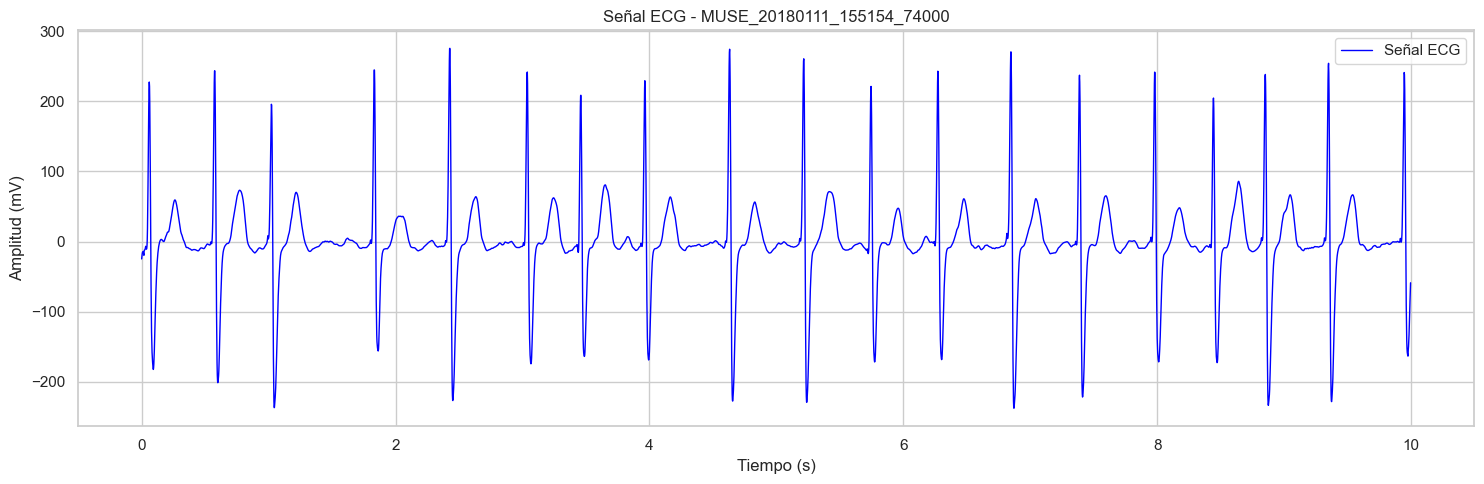

In [76]:
'''Revisamos que los archivos .parquet quedaron bien con la señal'''

# Datos
muestreo_hz = 500 # Dicho de donde se tomaron las señales para el trabajo
muestras_mostrar = 5000  # Muestras a visualizar
directorio_parquet = './data/processed/parquet/AFIB'

# Cargamos el archivos Parquet
archivos_parquet = glob.glob(f"{directorio_parquet}/*.parquet")[:1]  # Primer archivo

if not archivos_parquet:
    raise FileNotFoundError("No se encontraron archivos Parquet") # Verificar que no este vacio la carpeta



# Procesar los archivos .parquet
def procesar_ecg(archivo_parquet):
    # Leemos el archivo
    df = pd.read_parquet(archivo_parquet)
    
    # Verificamos la estructura
    print(f"\nEstructura del archivo: {df.shape[1]} columnas, {df.shape[0]} muestras")
    print("Primeras filas:")
    print(df.head())
    
    # Estructura
    if df.shape[1] == 2:
        # columnas del dataframe
        df.columns = ['timestamp', 'ecg_signal']
        # señal
        señal = df['ecg_signal'].values[:muestras_mostrar]
        tiempo = np.arange(len(señal)) / muestreo_hz
        
        # Grafica:
        plt.figure(figsize=(15, 5))
        plt.plot(tiempo, señal, label='Señal ECG', linewidth=1, color='blue')
        plt.title(f'Señal ECG - {Path(archivo_parquet).stem}')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud (mV)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return df, señal
    
    else:
        raise ValueError("Estructura de archivo no reconocida")


df_ecg, señal = procesar_ecg(archivos_parquet[0])
    
    


Procesando SR

Registro 1/20 - 4999 muestras


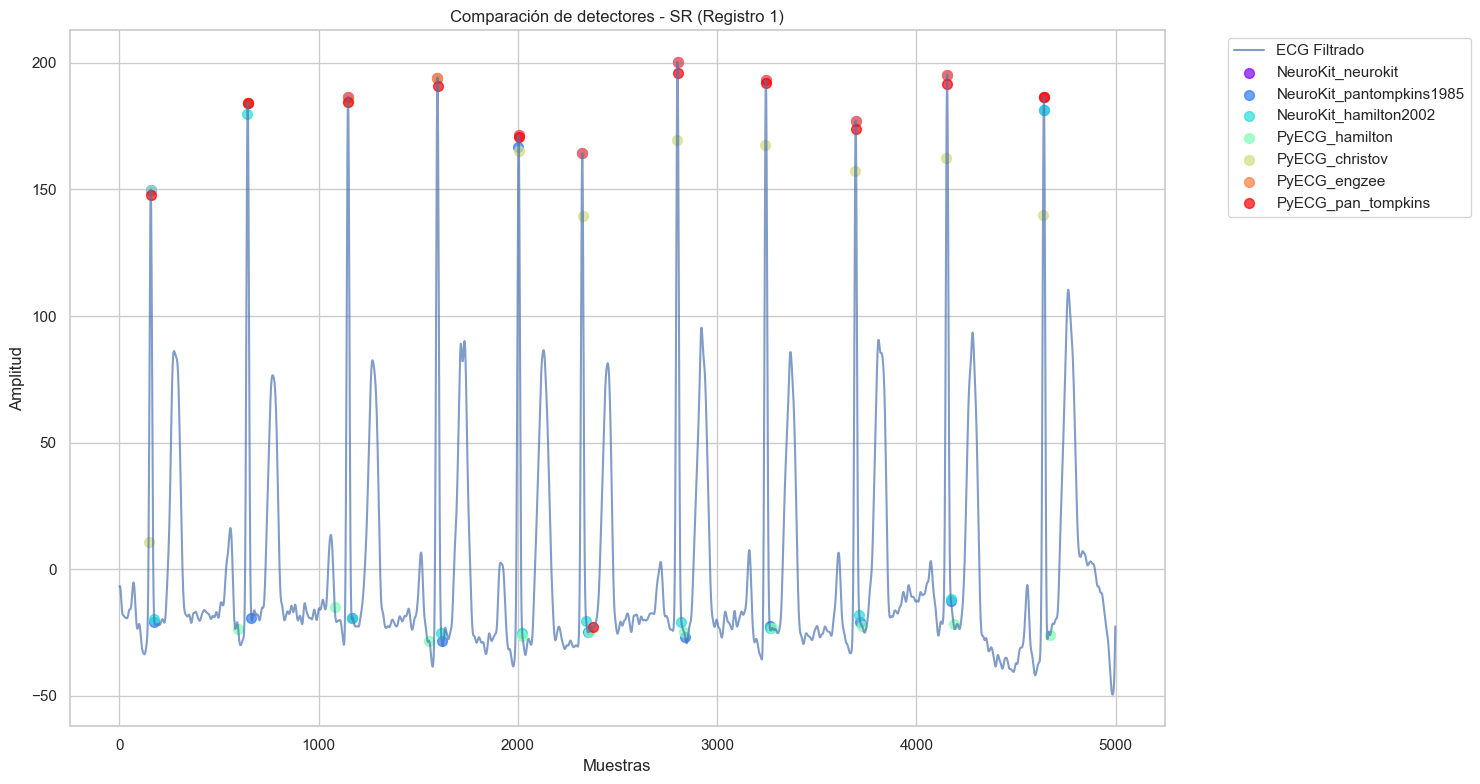


Registro 2/20 - 4999 muestras

Registro 3/20 - 4999 muestras

Registro 4/20 - 4999 muestras

Registro 5/20 - 4999 muestras

Registro 6/20 - 4999 muestras

Registro 7/20 - 4999 muestras

Registro 8/20 - 4999 muestras

Registro 9/20 - 4999 muestras

Registro 10/20 - 4999 muestras

Registro 11/20 - 4999 muestras

Registro 12/20 - 4999 muestras

Registro 13/20 - 4999 muestras

Registro 14/20 - 4999 muestras

Registro 15/20 - 4999 muestras

Registro 16/20 - 4999 muestras

Registro 17/20 - 4999 muestras

Registro 18/20 - 4999 muestras

Registro 19/20 - 4999 muestras

Registro 20/20 - 4999 muestras

Procesando AFIB

Registro 1/20 - 4999 muestras


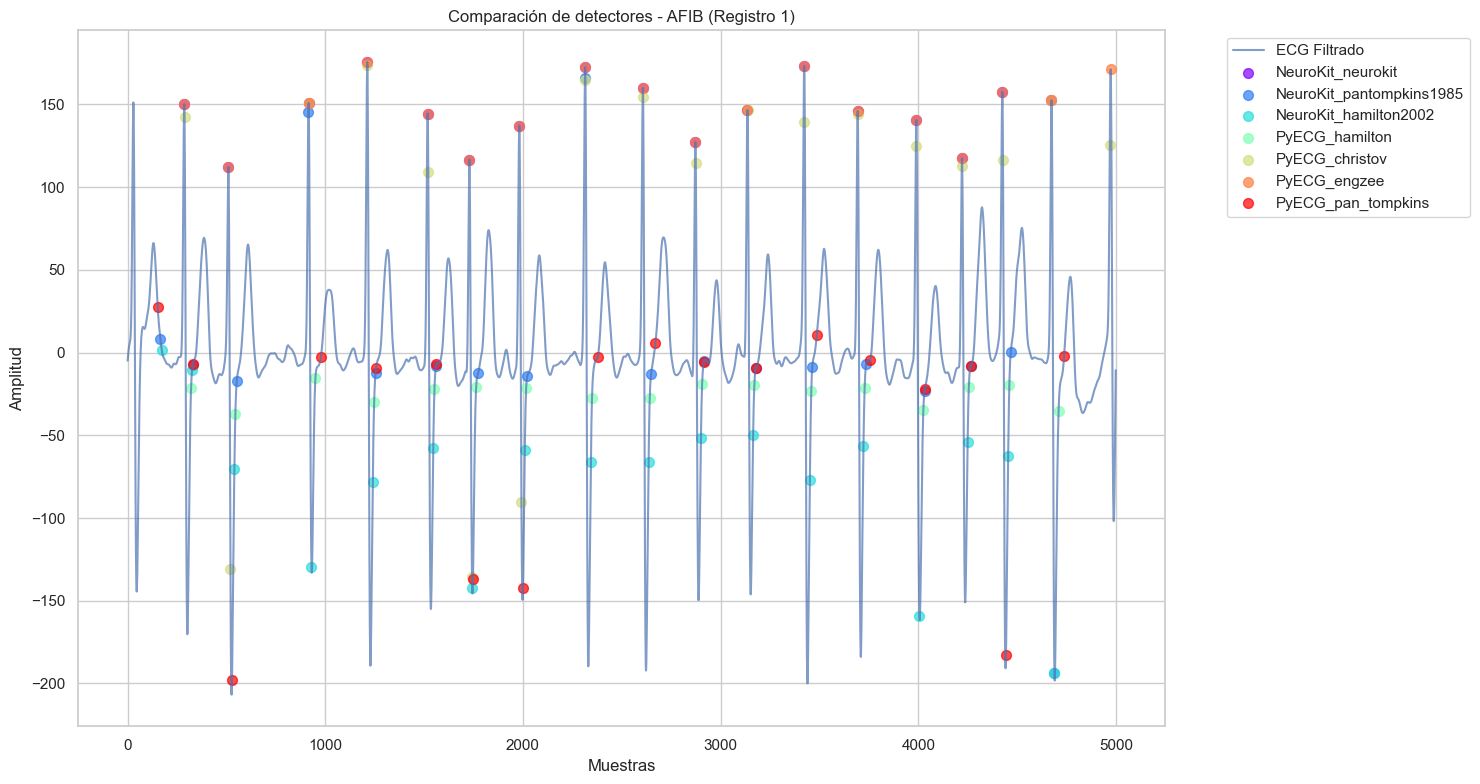


Registro 2/20 - 4999 muestras

Registro 3/20 - 4999 muestras

Registro 4/20 - 4999 muestras

Registro 5/20 - 4999 muestras

Registro 6/20 - 4999 muestras

Registro 7/20 - 4999 muestras

Registro 8/20 - 4999 muestras

Registro 9/20 - 4999 muestras

Registro 10/20 - 4999 muestras

Registro 11/20 - 4999 muestras

Registro 12/20 - 4999 muestras

Registro 13/20 - 4999 muestras

Registro 14/20 - 4999 muestras

Registro 15/20 - 4999 muestras

Registro 16/20 - 4999 muestras

Registro 17/20 - 4999 muestras

Registro 18/20 - 4999 muestras

Registro 19/20 - 4999 muestras

Registro 20/20 - 4999 muestras


RESULTADOS COMPARATIVOS

ANÁLISIS PARA SR

Resultados promediados (20 registros):
                          picos_promedio  tiempo_promedio
NeuroKit_pantompkins1985           12.25         0.000294
NeuroKit_neurokit                  12.05         0.001250
PyECG_pan_tompkins                 12.80         0.001899
PyECG_hamilton                     12.95         0.003428
NeuroKit_hamilton2002     

In [77]:
'''Analisis 2'''

# Datos
muestreo_hz = 500
num_registros = 20
arritmias = ['SR', 'AFIB']
base_path = './data/processed/parquet'

# Detectores
detectors = Detectors(muestreo_hz)
neurokit_methods = ['neurokit', 'pantompkins1985', 'hamilton2002']
py_ecg_methods = ['hamilton', 'christov', 'engzee', 'pan_tompkins']



# Cargamos 20 señales de ECG de cada arritmia
def cargar_registros(arritmia, n=20):
    archivos = glob.glob(f"{base_path}/{arritmia}/*.parquet")[:n]
    registros = [] # Lista para almacenar las señales ECG cargadas
    for archivo in archivos:
        df = pd.read_parquet(archivo)
        if 'ecg_signal' in df.columns:
            registros.append(df['ecg_signal'].values)
        elif len(df.columns) == 1:
            registros.append(df.iloc[:, 0].values)
    return registros



# Detectamos los picos R con diferentes métodos
def detectar_picos(señal, arritmia, registro_id):
    resultados = {} # Diccionario para almacenar los resultados de los picos detectados
    # NeuroKit2
    for method in neurokit_methods:
        start = time.time() # Iniciamos el conteo de tiempo para la detección
        _, nk_peaks = nk.ecg_peaks(señal, sampling_rate=muestreo_hz, method=method)
        tiempo = time.time() - start # Calcula el tiempo de ejecución
        resultados[f"NeuroKit_{method}"] = {
            'peaks': nk_peaks['ECG_R_Peaks'], # Picos detectados
            'tiempo': tiempo,
            'count': len(nk_peaks['ECG_R_Peaks']) # Numero de picos detectados
        }
    
    # py-ecg-detectors
    for method in py_ecg_methods:
        start = time.time() # Iniciamos el conteo de tiempo para la detección
        detector = getattr(detectors, f"{method}_detector")
        peaks = detector(señal)
        tiempo = time.time() - start
        resultados[f"PyECG_{method}"] = {
            'peaks': peaks, # Picos detectados
            'tiempo': tiempo,
            'count': len(peaks) # Numero de picos detectados
        }
    
    return resultados


analisis_completo = {} # Diccionario para almacenar el analisis completo por arritmia
# procesamiento:
for arritmia in arritmias:
    print(f"\n{'='*50}") # Imprime una línea separadora
    print(f"Procesando {arritmia}")
    print(f"{'='*50}") # Imprime una línea separadora
    
    señales = cargar_registros(arritmia, num_registros) # Cargar registros ECG de la arritmia
    analisis_arritmia = [] # Lista para almacenar los resultados del analisis de la arritmia
    
    for i, señal in enumerate(señales[:num_registros]): # iteramos sobre los registros cargados
        print(f"\nRegistro {i+1}/{len(señales)} - {len(señal)} muestras") # Imprimimos información sobre el registro actual
        
        # Preprocesamiento
        señal_filtrada = nk.ecg_clean(señal, sampling_rate=muestreo_hz)
        
        # Detección de picos
        resultados = detectar_picos(señal_filtrada, arritmia, i) # Detectamos los picos R de la señal
        analisis_arritmia.append(resultados) # Agregamos los resultados a la lista
        
        # Grafica (primer registro)
        if i == 0:
            plt.figure(figsize=(15, 8))
            plt.plot(señal_filtrada, label='ECG Filtrado', alpha=0.7)
            
            # Graficar picos de cada método
            colors = plt.cm.rainbow(np.linspace(0, 1, len(resultados))) # Colores para los picos de cada método
            for j, (metodo, datos) in enumerate(resultados.items()): # Iteramos sobre los resultados
                plt.scatter(datos['peaks'], señal_filtrada[datos['peaks']], # Grafica los picos
                          color=colors[j], s=50, label=metodo, alpha=0.7)
            
            plt.title(f"Comparación de detectores - {arritmia} (Registro 1)")
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    
    analisis_completo[arritmia] = analisis_arritmia # Almacenamos el análisis de la arritmia




# Analisis comparativo
print("\n\nRESULTADOS COMPARATIVOS")

for arritmia in arritmias:
    print(f"\n{'='*30}")
    print(f"ANÁLISIS PARA {arritmia}")
    print(f"{'='*30}")
    
    # Calcular promedios
    promedios = {} # Diccionario para almacenar los promedios de picos y tiempos
    for metodo in analisis_completo[arritmia][0].keys(): # Iteramos sobre los métodos de análisis
        counts = [r[metodo]['count'] for r in analisis_completo[arritmia]] # Lista de conteos de picos
        tiempos = [r[metodo]['tiempo'] for r in analisis_completo[arritmia]] # Lista de tiempos de detección
        
        promedios[metodo] = {
            'picos_promedio': np.mean(counts), # Promedio de picos detectados
            'tiempo_promedio': np.mean(tiempos) # Promedio del tiempo de detección
        }
    
    # Mostrar resultados
    df_resultados = pd.DataFrame.from_dict(promedios, orient='index')  # Crea un DataFrame con los promedios
    print(f"\nResultados promediados ({len(analisis_completo[arritmia])} registros):")
    print(df_resultados.sort_values('tiempo_promedio'))
    


In [ ]:
'''Analisis 3'''
'''Punto 1'''

# Datos
muestreo_hz = 500
arritmias = ['SA', 'AFIB', 'AF', 'SA', 'SB', 'ST', 'SVT'] # Arritmias
base_path = './data/processed/parquet'
resultados_picos = [] # Lista para almacenar los resultados de la detección de los picos R

# Inicializar detector Christov
detector = Detectors(muestreo_hz)

# Procesar cada archivo
for arritmia in arritmias:
    archivos = list(Path(base_path, arritmia).glob("*.parquet"))  # Todos los archivos .parquet
    
    for archivo in archivos:
        try:
            # Cargar señal
            df = pd.read_parquet(archivo)
            señal = df['ecg_signal'].values # Obtener la señal ECG
            
            # Detectar picos R con Christov
            picos_r = detector.christov_detector(señal) # Detectamos los picos R en la señal ECG
            
            # Guardar resultados
            resultados_picos.append({
                'archivo': Path(archivo).name,
                'arritmia': arritmia,
                'num_picos': len(picos_r),
                'picos_r': picos_r
            })
        except Exception as e:
            print(f"Error procesando {archivo}: {str(e)}") # Imprimimos error si no se puede procesar el archivo

# Convertir a DataFrame
df_picos = pd.DataFrame(resultados_picos) # Convertir los resultados a un DataFrame
print("\nResumen de detección de picos R:")
print(df_picos.groupby('arritmia')['num_picos'].describe())

# Guardar resultados intermedios
df_picos.to_pickle('./resultados_picos_r.pkl')
print("\nResultados de picos R guardados en 'resultados_picos_r.pkl'")

Error procesando data\processed\parquet\SVT\MUSE_20181222_204118_08000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204121_42000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204122_52000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204131_50000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204143_03000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204146_34000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204157_58000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204212_44000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204217_03000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204219_27000.parquet: pop from empty list



Procesando 1357 archivos en SR...

Procesando 1548 archivos en AFIB...

Procesando 370 archivos en AF...

Procesando 132 archivos en SA...

Procesando 3317 archivos en SB...

Procesando 1066 archivos en ST...

Procesando 396 archivos en SVT...
Error procesando data\processed\parquet\SVT\MUSE_20181222_204118_08000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204121_42000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204122_52000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204131_50000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204143_03000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204146_34000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_20181222_204157_58000.parquet: pop from empty list
Error procesando data\processed\parquet\SVT\MUSE_201812

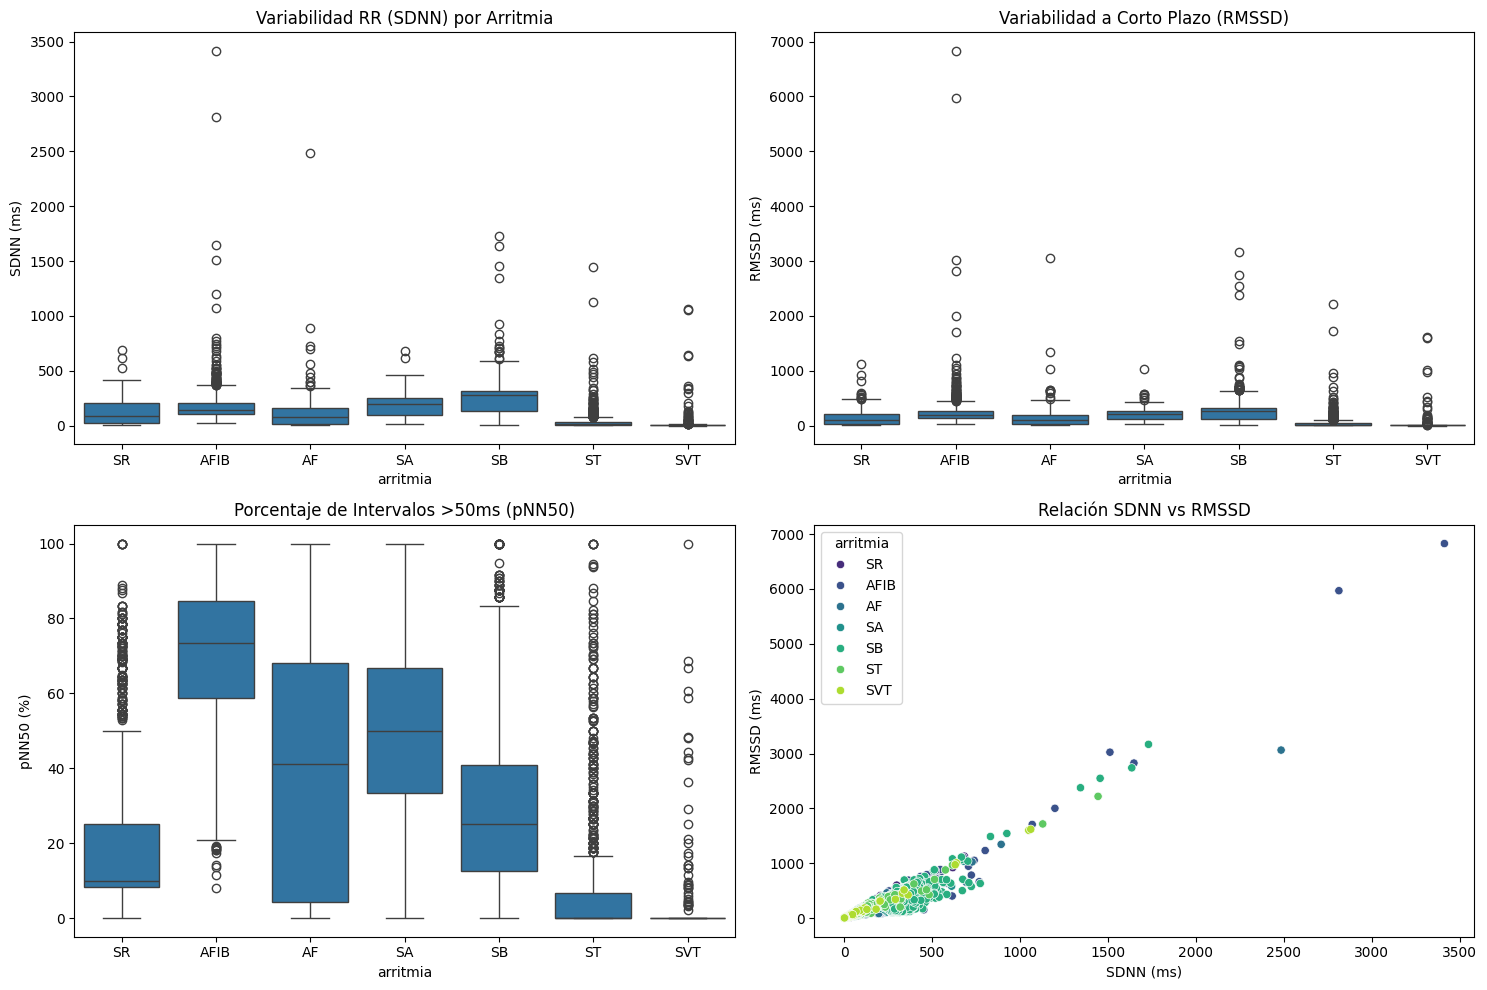

In [ ]:
'''Punto 2 y 3'''
# Configuración inicial
muestreo_hz = 500
arritmias = ['SR', 'AFIB', 'AF', 'SA', 'SB', 'ST', 'SVT'] 
base_path = './data/processed/parquet'
resultados_hrv = [] # Lista para almacenar los resultados de HRV

# Inicializar detector
detector = Detectors(muestreo_hz)

# Función para calcular métricas HRV básicas
def calcular_hrv(rr_intervals):
    if len(rr_intervals) < 2:
        return None
    
    rr_diff = np.diff(rr_intervals)
    
    return {
        'mean_rr': np.mean(rr_intervals),
        'sdn_rr': np.std(rr_intervals),          # SDNN
        'rmssd': np.sqrt(np.mean(rr_diff**2)),   # RMSSD
        'nn50': np.sum(np.abs(rr_diff) > 50),    # NN50
        'pnn50': (np.sum(np.abs(rr_diff) > 50) / len(rr_diff)) * 100  # Porcentaje de NN50
    }

# Procesar cada archivo
for arritmia in arritmias:
    archivos = list(Path(base_path, arritmia).glob("*.parquet"))
    print(f"\nProcesando {len(archivos)} archivos en {arritmia}...")
    
    for archivo in archivos:
        try:
            # Cargar señal
            df = pd.read_parquet(archivo)
            señal = df['ecg_signal'].values
            
            # Detectar picos R con Christov
            picos_r = detector.christov_detector(señal)
            
            # Calcular intervalos RR en ms
            rr_intervals = np.diff(picos_r) * (1000/muestreo_hz) if len(picos_r) > 1 else np.array([])
            
            # Calcular métricas HRV
            hrv_metrics = calcular_hrv(rr_intervals) # Calcular métricas HRV
            
            if hrv_metrics:
                resultados_hrv.append({
                    'archivo': archivo.name,
                    'arritmia': arritmia,
                    'num_picos': len(picos_r),
                    'rr_intervals': rr_intervals.tolist(),  # Guardamos los intervalos RR
                    **hrv_metrics
                })
        except Exception as e:
            print(f"Error procesando {archivo}: {str(e)}")

# Convertir a DataFrame
df_hrv = pd.DataFrame(resultados_hrv)

# Análisis de resultados
print("\nResumen de métricas HRV por arritmia:")
print(df_hrv.groupby('arritmia')[['mean_rr', 'sdn_rr', 'rmssd', 'pnn50']].agg(['mean', 'std']))

# Grafica
plt.figure(figsize=(15, 10))

# Boxplot de SDNN
plt.subplot(2, 2, 1)
sns.boxplot(x='arritmia', y='sdn_rr', data=df_hrv, order=arritmias)
plt.title('Variabilidad RR (SDNN) por Arritmia')
plt.ylabel('SDNN (ms)')

# Boxplot de RMSSD
plt.subplot(2, 2, 2)
sns.boxplot(x='arritmia', y='rmssd', data=df_hrv, order=arritmias)
plt.title('Variabilidad a Corto Plazo (RMSSD)')
plt.ylabel('RMSSD (ms)')

# Boxplot de pNN50
plt.subplot(2, 2, 3)
sns.boxplot(x='arritmia', y='pnn50', data=df_hrv, order=arritmias)
plt.title('Porcentaje de Intervalos >50ms (pNN50)')
plt.ylabel('pNN50 (%)')

# Relación entre SDNN y RMSSD
plt.subplot(2, 2, 4)
sns.scatterplot(x='sdn_rr', y='rmssd', hue='arritmia', data=df_hrv, palette='viridis')
plt.title('Relación SDNN vs RMSSD')
plt.xlabel('SDNN (ms)')
plt.ylabel('RMSSD (ms)')

plt.tight_layout()
plt.show()

In [40]:
print(df_hrv.columns)

Index(['archivo', 'arritmia', 'num_picos', 'rr_intervals', 'mean_rr', 'sdn_rr',
       'rmssd', 'nn50', 'pnn50'],
      dtype='object')



RESUMEN ESTADÍSTICO POR ARRITMIA:
          count    mean     std  median    min      max
arritmia                                               
AF          370  143.69  211.81  100.97   1.72  3062.46
AFIB       1548  230.09  279.54  188.10  26.93  6828.00
SA          132  214.21  138.48  208.16  23.38  1035.95
SB         3315  240.95  172.11  272.37   6.80  3166.81
SR         1356  133.70  123.53  101.46   3.16  1128.10
ST         1066   48.61  116.60   13.90   1.51  2218.60
SVT         374   30.38  145.63    5.69   0.70  1618.91

COMPARACIÓN: SR (n=1356) vs AFIB (n=1548)

Prueba de normalidad (Shapiro-Wilk):
SR: W=0.857, p=0.0000 (No normal)
AFIB: W=0.299, p=0.0000 (No normal)

Prueba de homocedasticidad (Levene):
F=0.360, p=0.5486 (Varianzas iguales)

Prueba U de Mann-Whitney (no paramétrica):
U=629346, p=0.0000 (SIG)

COMPARACIÓN: SR (n=1356) vs AF (n=370)

Prueba de normalidad (Shapiro-Wilk):
SR: W=0.857, p=0.0000 (No normal)
AF: W=0.504, p=0.0000 (No normal)

Prueba de homoceda

C:\Users\fabio\AppData\Local\Temp\ipykernel_21528\1522749165.py:65: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_hrv[df_hrv['arritmia'] == arritmia]['rmssd'].dropna(),
C:\Users\fabio\AppData\Local\Temp\ipykernel_21528\1522749165.py:65: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_hrv[df_hrv['arritmia'] == arritmia]['rmssd'].dropna(),
C:\Users\fabio\AppData\Local\Temp\ipykernel_21528\1522749165.py:65: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_hrv[df_hrv['arritmia'] == arritmia]['rmssd'].dropna(),
C:\Users\fabio\AppData\Local\Temp\ipykernel_21528\1522749165.py:65: FutureWarning: 

`shade` is now deprecated i

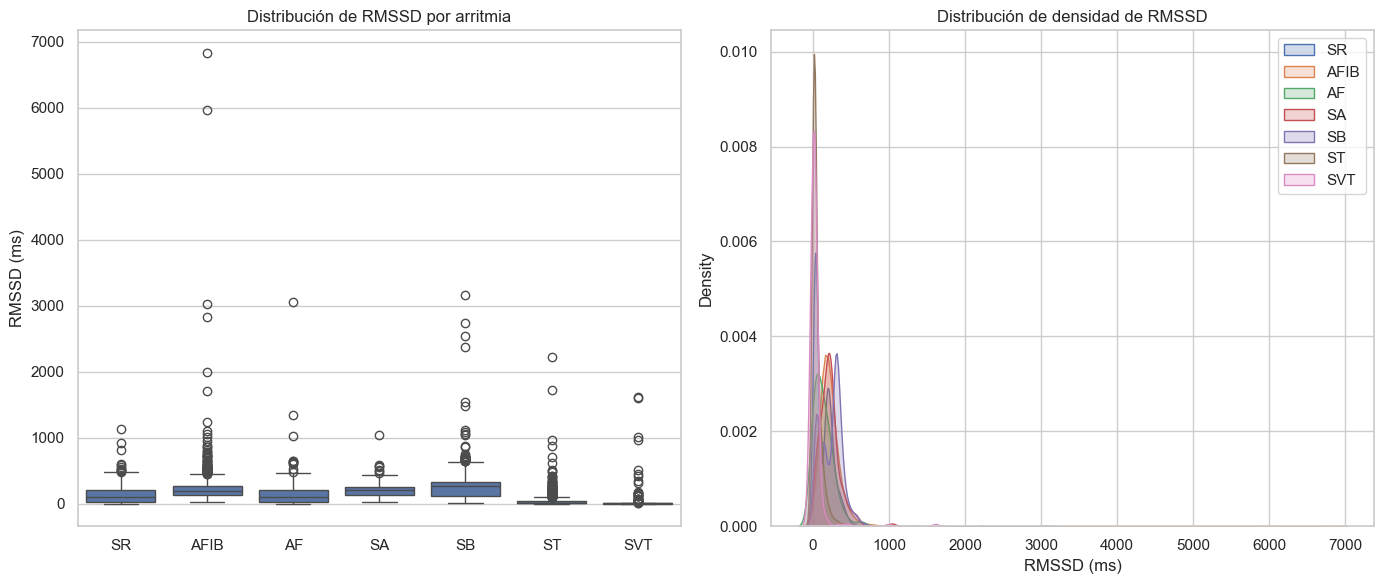

In [80]:
'''Punto 4'''

def analizar_rmssd_completo(df_hrv):
    # Analisis descriptivo
    print("\nRESUMEN ESTADÍSTICO POR ARRITMIA:")
    stats_df = df_hrv.groupby('arritmia')['rmssd'].agg(['count', 'mean', 'std', 'median', 'min', 'max'])
    print(stats_df.round(2))
    
    # comparamos por pares entre arritmias
    arritmias = df_hrv['arritmia'].unique()
    
    for i in range(len(arritmias)):
        for j in range(i+1, len(arritmias)):
            arritmia1, arritmia2 = arritmias[i], arritmias[j] # Obtenemos pares de arritmias
            data1 = df_hrv[df_hrv['arritmia'] == arritmia1]['rmssd'].dropna() # Datos de RMSSD de la arritmia 1
            data2 = df_hrv[df_hrv['arritmia'] == arritmia2]['rmssd'].dropna() # Datos de RMSSD de la arritmia 2
            
            if len(data1) < 3 or len(data2) < 3: # Verificamos si hay suficientes datos para la comparación
                print(f"\n{arritmia1} vs {arritmia2}: Muestras insuficientes para comparar")
                continue
                
            print(f"\nCOMPARACIÓN: {arritmia1} (n={len(data1)}) vs {arritmia2} (n={len(data2)})")
            
            # Pruebas de normalidad
            shapiro1 = stats.shapiro(data1) # Arritmia 1
            shapiro2 = stats.shapiro(data2) # Arritmia 2
            
            print(f"\nPrueba de normalidad (Shapiro-Wilk):")
            print(f"{arritmia1}: W={shapiro1.statistic:.3f}, p={shapiro1.pvalue:.4f} {'(Normal)' if shapiro1.pvalue>0.05 else '(No normal)'}")
            print(f"{arritmia2}: W={shapiro2.statistic:.3f}, p={shapiro2.pvalue:.4f} {'(Normal)' if shapiro2.pvalue>0.05 else '(No normal)'}")
            
            # Prueba de homocedasticidad
            levene_test = levene(data1, data2)
            print(f"\nPrueba de homocedasticidad (Levene):")
            print(f"F={levene_test.statistic:.3f}, p={levene_test.pvalue:.4f} {'(Varianzas iguales)' if levene_test.pvalue>0.05 else '(Varianzas diferentes)'}")

            
            # Selección de prueba estadística
            normal = (shapiro1.pvalue > 0.05) and (shapiro2.pvalue > 0.05) # Verificar normalidad
            var_iguales = levene_test.pvalue > 0.05 # Verificar homocedasticidad
            
            if normal and var_iguales:
                # Prueba t paramétrica
                t, p = stats.ttest_ind(data1, data2, equal_var=True) # Prueba t paramétrica si los datos son normales y tienen varianzas iguales
                print(f"\nPrueba t de Student (varianzas iguales):")
                print(f"t={t:.3f}, p={p:.4f} {'(NS)' if p>0.05 else '(SIG)'}")
            else:
                # Prueba U Mann-Whitney si no se cumplen las condiciones
                u, p = stats.mannwhitneyu(data1, data2) 
                print(f"\nPrueba U de Mann-Whitney (no paramétrica):")
                print(f"U={u:.0f}, p={p:.4f} {'(NS)' if p>0.05 else '(SIG)'}")
            
    
    # Graficas
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='arritmia', y='rmssd', data=df_hrv)
    plt.title('Distribución de RMSSD por arritmia')
    plt.ylabel('RMSSD (ms)')
    plt.xlabel('')
    
    plt.subplot(1, 2, 2)
    for arritmia in arritmias:
        sns.kdeplot(df_hrv[df_hrv['arritmia'] == arritmia]['rmssd'].dropna(), 
                   label=arritmia, shade=True)
    plt.title('Distribución de densidad de RMSSD')
    plt.xlabel('RMSSD (ms)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

analizar_rmssd_completo(df_hrv)

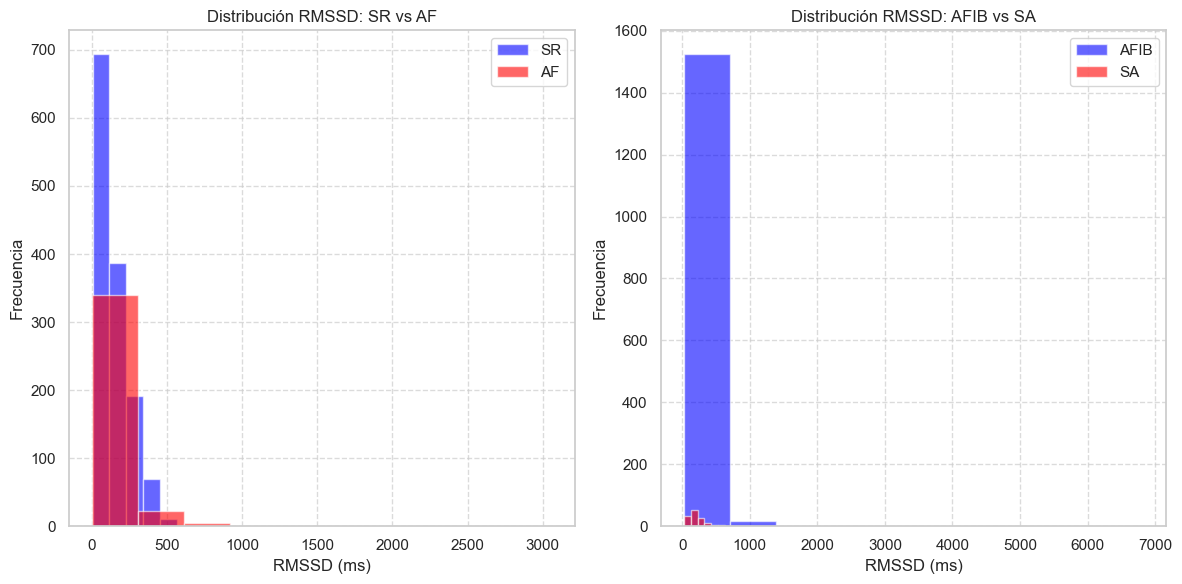

C:\Users\fabio\AppData\Local\Temp\ipykernel_21528\4037866752.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([datos1, datos2], labels=[grupo3, grupo4])
C:\Users\fabio\AppData\Local\Temp\ipykernel_21528\4037866752.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([datos1, datos2], labels=[grupo3, grupo4])


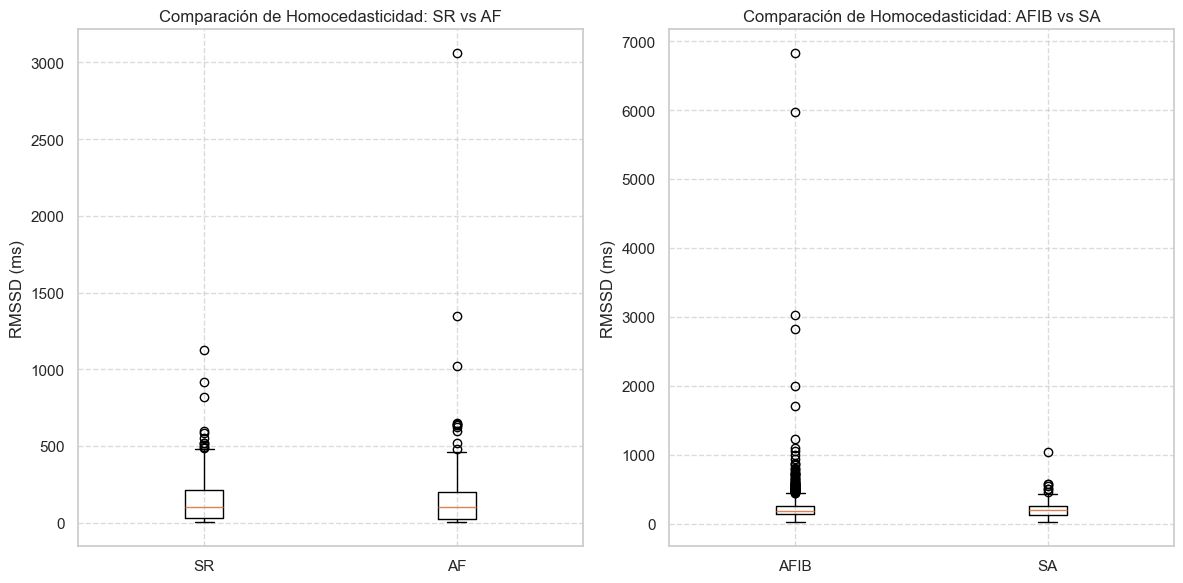

In [ ]:
'''Graficas para prueba de hipotesis'''

def histogramas_superpuestos_rmssd(df_hrv):
    comparaciones = [
        ('SR', 'AF'),
        ('AFIB', 'SA')
    ]
    
    plt.figure(figsize=(12, 6))  
    for i, (grupo1, grupo2) in enumerate(comparaciones, start=1):
        plt.subplot(1, 2, i) 
        # Extraemos los datos de RMSSD
        datos1 = df_hrv[df_hrv['arritmia'] == grupo1]['rmssd'].dropna()
        datos2 = df_hrv[df_hrv['arritmia'] == grupo2]['rmssd'].dropna()
        
        # histograma
        plt.hist(datos1, bins=10, alpha=0.6, label=grupo1, color='blue')
        plt.hist(datos2, bins=10, alpha=0.6, label=grupo2, color='red')
        
        plt.title(f'Distribución RMSSD: {grupo1} vs {grupo2}')
        plt.xlabel('RMSSD (ms)')
        plt.ylabel('Frecuencia')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

histogramas_superpuestos_rmssd(df_hrv)



def homocedasticidad(df_hrv):
    comparaciones = [
        ('SR', 'AF'),
        ('AFIB', 'SA')
    ]
    
    plt.figure(figsize=(12, 6)) 
    for i, (grupo3, grupo4) in enumerate(comparaciones, start=1):
        plt.subplot(1, 2, i) 
        # Extraemos los datos de RMSSD
        datos1 = df_hrv[df_hrv['arritmia'] == grupo3]['rmssd'].dropna()
        datos2 = df_hrv[df_hrv['arritmia'] == grupo4]['rmssd'].dropna()
        
        # Boxplot para la comparación
        plt.boxplot([datos1, datos2], labels=[grupo3, grupo4])
        plt.title(f'Comparación de Homocedasticidad: {grupo3} vs {grupo4}')
        plt.ylabel('RMSSD (ms)')
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

homocedasticidad(df_hrv)
